# Baseline: Top-5 Booking Frequency (MAP@5)

To ensure reproducibility across the team, baseline evaluation is performed on a shared 100k sample. While larger local samples were used for exploratory analysis, the baseline serves as a consistent reference point rather than a performance upper bound.

In [10]:
import pandas as pd
import numpy as np

import sys
sys.path.insert(0, "..")
df_model = pd.read_parquet("../data/processed/df_model.parquet")
df_model.shape

(2988177, 173)

In [17]:
df_s = df_model.sample(n=100_000, random_state=42)
print("Sample shape:", df_s.shape)

Sample shape: (100000, 173)


The baseline assumes that, in the absence of user or context information, recommending the globally most frequently booked hotel clusters provides a strong reference point for ranking performance under MAP@5.

In [18]:
# Compute the Top-5 most frequent clusters (the baseline itself)
top5_clusters = (
    df_s["hotel_cluster"]
    .value_counts()
    .head(5)
    .index
    .tolist()
)

top5_clusters


[91, 48, 42, 28, 59]

### MAP@5 explained

MAP@5 is a ranking metric, not accuracy.

For each booking:

- You predict 5 hotel clusters in order

You get:

- 1.0 if the true cluster is ranked 1st

- 0.5 if ranked 2nd

- 0.33 if ranked 3rd

- 0.25 if ranked 4th

- 0.20 if ranked 5th

- 0.0 if not in top-5

Then you average this score over all bookings.

In [19]:
# implement MAP@5
def apk(actual, predicted, k=5):
    """
    Average Precision at k
    actual: true label (single value)
    predicted: list of predicted labels
    """
    if actual in predicted[:k]:
        return 1.0 / (predicted.index(actual) + 1)
    return 0.0

and now: Compute MAP@5 for the baseline

For each booking:

- compares the true hotel_cluster against the same baseline list: top5_clusters

- Computes the average precision

- Averages over all bookings → MAP@5

In [21]:

# apply baseline prediction to every booking
baseline_map5 = np.mean([
    apk(actual, top5_clusters, k=5)
    for actual in df_s["hotel_cluster"]
])

baseline_map5

0.07210749999999999

A simple popularity-based baseline achieves MAP@5 ≈ 0.074, confirming that global popularity alone captures some signal, but leaves substantial room for improvement through contextual features.

in other words:
MAP@5 ≈ 0.074 means
“On average, the true hotel cluster appears somewhere in the top-5 with low-to-moderate rank-weighted frequency.”

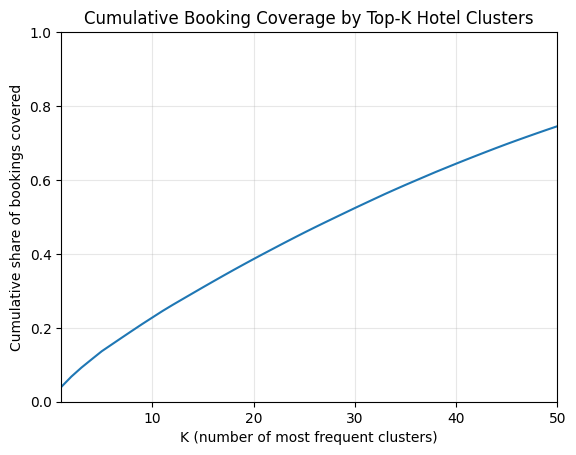

Top-1: 4.0% of bookings covered
Top-3: 9.2% of bookings covered
Top-5: 13.7% of bookings covered
Top-10: 22.8% of bookings covered
Top-20: 38.6% of bookings covered
Top-50: 74.5% of bookings covered


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Booking counts per cluster (descending)
counts = df_s["hotel_cluster"].value_counts()

# Cumulative coverage: share of bookings covered by the top-k most frequent clusters
cum_share = counts.cumsum() / counts.sum()

# Plot: cumulative share vs k
k = np.arange(1, len(cum_share) + 1)

plt.plot(k, cum_share.values)
plt.title("Cumulative Booking Coverage by Top-K Hotel Clusters")
plt.xlabel("K (number of most frequent clusters)")
plt.ylabel("Cumulative share of bookings covered")
plt.xlim(1, 50)  # show top 50 for readability; change if you want
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.show()

# Optional: print a few key points for slide annotations
for kk in [1, 3, 5, 10, 20, 50]:
    if kk <= len(cum_share):
        print(f"Top-{kk}: {cum_share.iloc[kk-1]:.1%} of bookings covered")


The cumulative coverage plot shows that while a small number of hotel clusters account for a large share of bookings, a long tail remains, highlighting both the strength of a popularity baseline and the need for contextual ranking models.

A popularity-based baseline covers approximately 14% of bookings within its top-5 recommendations. However, because correct clusters often appear at lower ranks, the resulting MAP@5 score is only ~0.074, highlighting substantial room for improvement through contextual features.

In [23]:
def hit_rate_at_k(y_true, y_pred, k=5):
    """
    Calculate hit rate at k for baseline evaluation.
    
    Hit rate measures the proportion of actual bookings where the true 
    hotel cluster appears in the top-k predicted clusters.
    
    Args:
        y_true: array of true hotel clusters from df_s
        y_pred: list of predicted hotel clusters (e.g., top5_clusters)
        k: number of predictions to consider (default=5)
    
    Returns:
        Hit rate (float between 0 and 1)
    """
    hits = sum(1 for true_val in y_true if true_val in y_pred[:k])
    return hits / len(y_true)

# Calculate hit rate at 5 for the baseline
hit5 = hit_rate_at_k(df_s["hotel_cluster"].values, top5_clusters, k=5)
print(f"Hit Rate @ 5: {hit5:.4f}")
hit5

Hit Rate @ 5: 0.1366


0.13662